## Environment set up and import Libraries

In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
with tf.device(device_name):
  print(device_name.split(":")[1]," running . . . ")

GPU  running . . . 


In [70]:
import tensorflow as tf
import os,sys
import numpy as np
import random

random.seed(1)
np.random.seed(1)
tf.random.set_seed(2)

In [71]:
import os, keras, numpy,tensorflow
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from numpy import *
from numpy.random import *
from keras.datasets.fashion_mnist import load_data
from keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.layers import *
from tensorflow.keras import initializers

## **Discriminator** Model

In [72]:
def define_discriminator(in_shape=(64,64,3),n_classes=5):

    # input level
    label_layer_1 = Input(shape=(1,), name = "input_label")
    label_layer_2 = Embedding(n_classes, 100)(label_layer_1)
    label_layer_3 = Dense(in_shape[0] * in_shape[1])(label_layer_2)
    label_layer_4 = Reshape((in_shape[0], in_shape[1], 1))(label_layer_3)
    # (64, 64, 1)

    # input image
    input_image = Input(shape=in_shape, name = "input_image")
    # (64, 64, 3)

    concat_layer = Concatenate()([input_image, label_layer_4])
    # (64, 64, 4)

    conv2d_layer_1 = Conv2D(filters = 16, kernel_size = (3,3), strides = (2,2), padding='same')(concat_layer)
    conv2d_layer_1 = LeakyReLU(alpha=0.3)(conv2d_layer_1)
    # (32, 32, 16)

    conv2d_layer_2 = Conv2D(filters = 32, kernel_size = (3,3), strides = (2,2), padding = 'same')(conv2d_layer_1)
    conv2d_layer_2 = LeakyReLU(alpha=0.3)(conv2d_layer_2)
    # (16, 16, 32)

    conv2d_layer_3 = Conv2D(filters = 64, kernel_size = (3,3),  strides = (2,2), padding = 'same')(conv2d_layer_2)
    conv2d_layer_3 = LeakyReLU(alpha=0.3)(conv2d_layer_3)
    # (8, 8, 64)

    conv2d_layer_4 = Conv2D(filters = 128, kernel_size = (3,3), strides = (2,2), padding = 'same')(conv2d_layer_3)
    conv2d_layer_4 = LeakyReLU(alpha=0.3)(conv2d_layer_4)
    # (4, 4, 128)

    flatten_layer = Flatten()(conv2d_layer_4)
    # (4 * 4 * 128)

    dropout_layer = Dropout(rate=0.4)(flatten_layer)
    # (4 * 4 * 128)

    dense_layer = Dense(128*8, activation='relu')(dropout_layer)
    # (8 * 128)

    # final layer
    output_layer = Dense(1, activation='sigmoid')(dense_layer)
    # (1,)

    model = Model([input_image,label_layer_1], output_layer)

    opt = Adam(learning_rate= 3e-4, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

a = define_discriminator()
a.summary()

Model: "model_31"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_label (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 embedding_21 (Embedding)       (None, 1, 100)       500         ['input_label[0][0]']            
                                                                                                  
 dense_51 (Dense)               (None, 1, 4096)      413696      ['embedding_21[0][0]']           
                                                                                                  
 input_image (InputLayer)       [(None, 64, 64, 3)]  0           []                               
                                                                                           

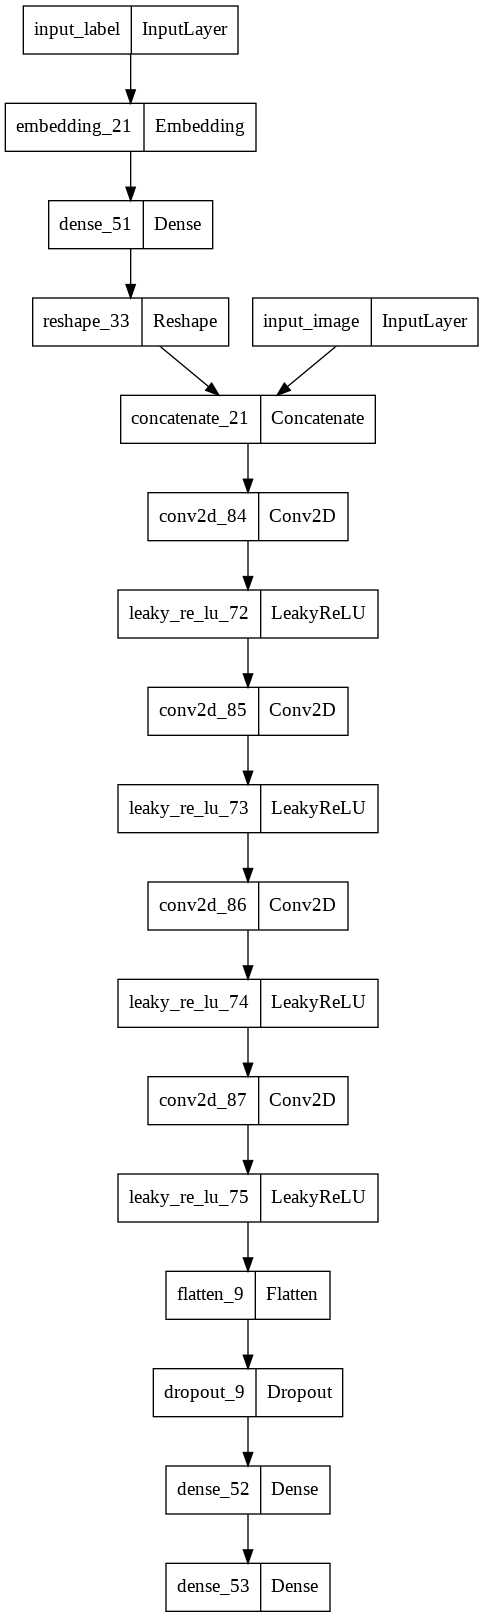

In [73]:
# plot the discriminator model
tf.keras.utils.plot_model(a)

## **Generator** Model

In [74]:
def define_generator(latent_dim = 100, n_classes = 5):

    # input level
    label_layer_1 = Input(shape=(1,), name = "input_label")
    label_layer_2 = Embedding(n_classes, 100)(label_layer_1)
    label_layer_3 = Dense(8 * 8)(label_layer_2)
    label_layer_4 = Reshape((8, 8, 1))(label_layer_3)
    # (8, 8, 1)

    # latent input
    latent_layer = Input(shape=(latent_dim,), name = "input_latent")

    layer_2 = Dense(128 * 8 * 8)(latent_layer)
    layer_2 = Activation("relu")(layer_2)
    layer_2 = Reshape((8, 8, 128))(layer_2)
    layer_2_1 = BatchNormalization(momentum = 0.8)(layer_2)
    # (8, 8, 128)


    concat_layer_1 = Concatenate()([layer_2_1, label_layer_4])
    # (8, 8, 129)

    layer_3 = Conv2DTranspose(filters = 128, kernel_size = (3,3), strides=(2,2), padding='same')(concat_layer_1)
    layer_3 = Conv2D(filters = 128, kernel_size = (3,3), padding='same', kernel_initializer = initializers.RandomNormal(0,0.8))(layer_3)
    layer_3 = BatchNormalization(momentum = 0.8)(layer_3)
    layer_3 = LeakyReLU(alpha=0.4)(layer_3)
    # (16, 16, 128)

    layer_4 = Conv2DTranspose(filters = 128, kernel_size = (3,3), strides=(2,2), padding='same')(layer_3)
    layer_4 = Conv2D(filters = 128, kernel_size = (3,3), padding='same',kernel_initializer = initializers.RandomNormal(0,0.8))(layer_4)
    layer_4 = BatchNormalization(momentum = 0.8)(layer_4)
    layer_4 = LeakyReLU(alpha=0.4)(layer_4)
    # (32, 32, 128)

    layer_5 = Conv2DTranspose(filters = 256, kernel_size = (3,3), strides=(2,2), padding='same')(layer_4)
    layer_5 = Conv2D(filters = 256, kernel_size = (3,3), padding='same',kernel_initializer = initializers.RandomNormal(0,0.8))(layer_5)
    layer_5 = BatchNormalization(momentum = 0.8)(layer_5)
    layer_5 = LeakyReLU(alpha=0.4)(layer_5)
    # (64, 64, 128)

    # final layer
    output_layer = Conv2D(filters = 3, kernel_size = (3,3), strides=(1,1), activation='tanh', padding='same')(layer_5)

    model = Model([latent_layer,label_layer_1], output_layer)
    return model

b = define_generator(512)
b.summary()

Model: "model_32"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_latent (InputLayer)      [(None, 512)]        0           []                               
                                                                                                  
 dense_55 (Dense)               (None, 8192)         4202496     ['input_latent[0][0]']           
                                                                                                  
 input_label (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 activation_12 (Activation)     (None, 8192)         0           ['dense_55[0][0]']               
                                                                                           

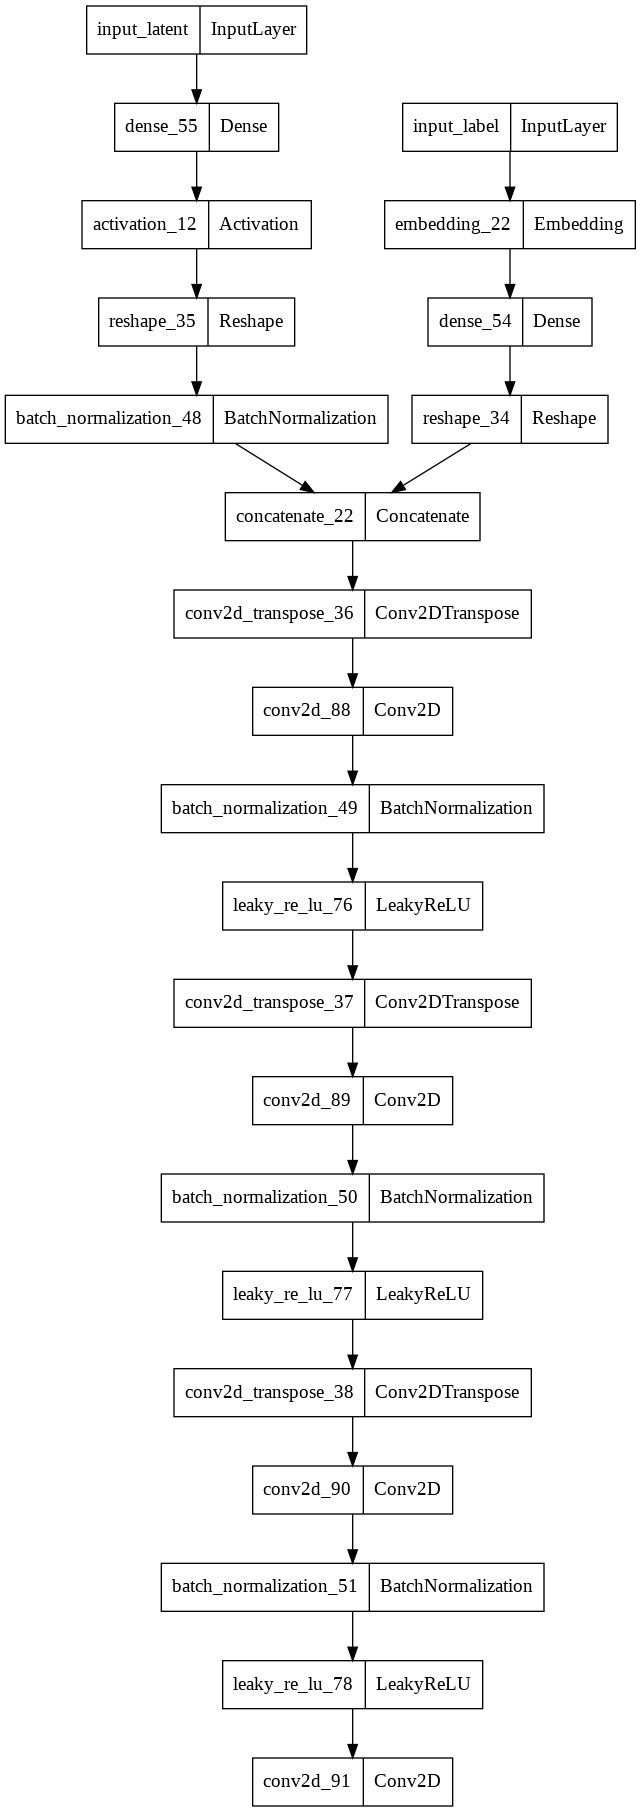

In [75]:
# plot the generator model
tf.keras.utils.plot_model(b)

## **Combine** or **GAN** Model

In [76]:
def define_gan(g_model, d_model):

  d_model.trainable = False

  g_latent, g_label = g_model.input
  g_output = g_model.output

  d_output = d_model([g_output,g_label])

  model = Model([g_latent, g_label], d_output)

  opt = Adam(learning_rate= 3e-4, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt,  metrics=['accuracy'])
  
  return model
c = define_gan(b, a)
c.summary()

Model: "model_33"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_latent (InputLayer)      [(None, 512)]        0           []                               
                                                                                                  
 dense_55 (Dense)               (None, 8192)         4202496     ['input_latent[0][0]']           
                                                                                                  
 input_label (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 activation_12 (Activation)     (None, 8192)         0           ['dense_55[0][0]']               
                                                                                           

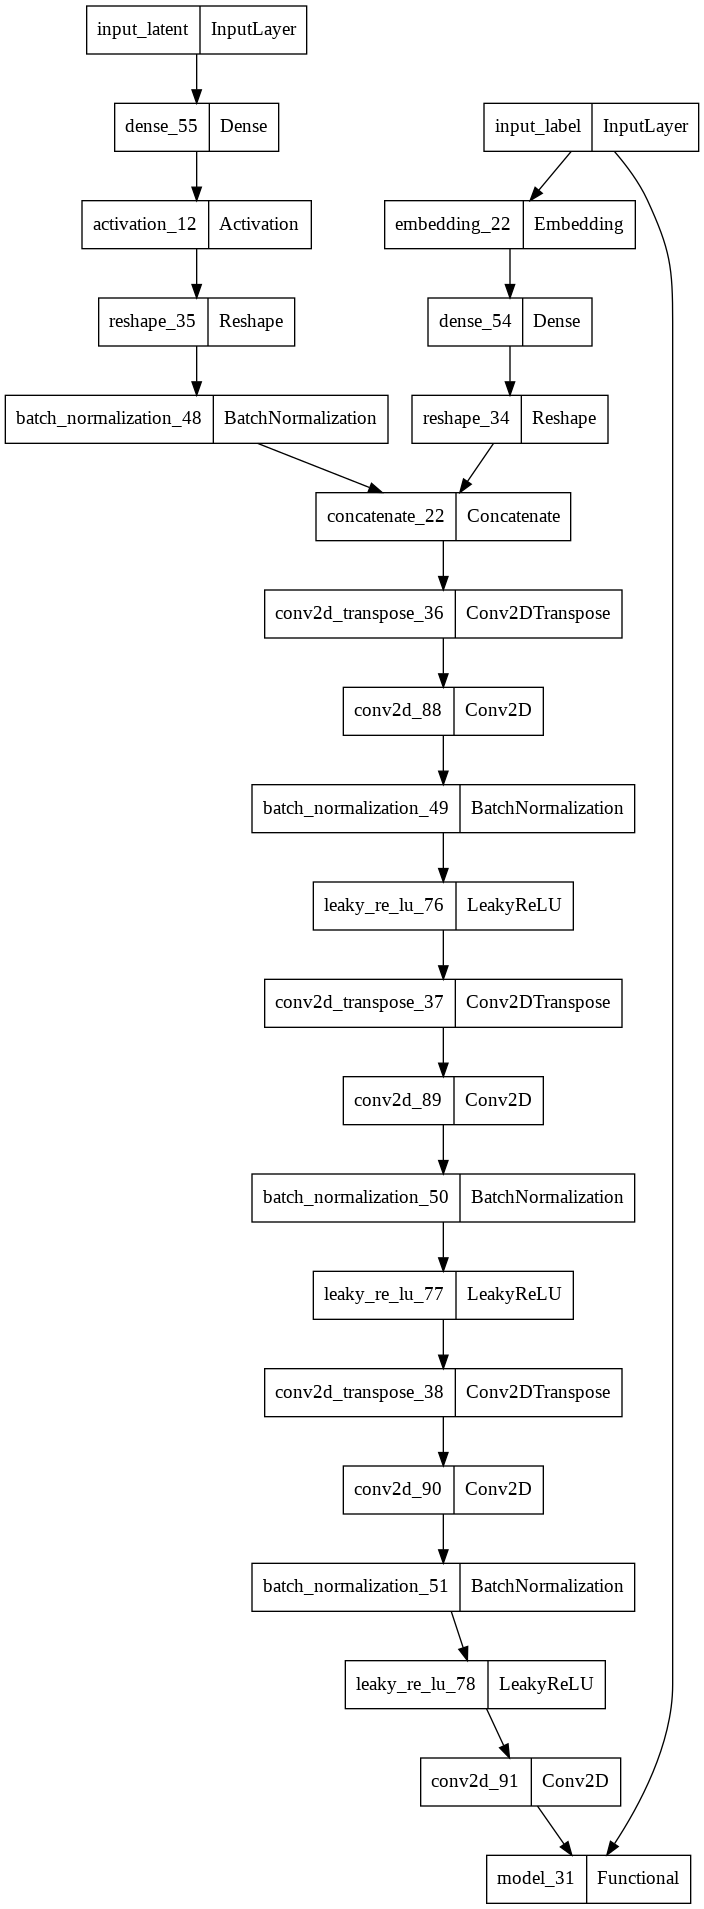

In [77]:
# plot GAN model
tf.keras.utils.plot_model(c)

## Load Dataset

In [78]:
def load_real_samples():
  # load dataset
  data = np.load("/content/drive/MyDrive/Animo/DataSet1/animo_file_10000.npz")
  data = data['a']
  data = np.array(data)
  X = data.astype('float32')
  # scale from [0,255] to [-1,1]
  X = (X - 127.5) / 127.5
  return X
k = load_real_samples()
print("image: ",k.shape)
print("\nshape/size of the first 16 data: ",k[:16].shape)

image:  (10000, 64, 64, 3)

shape/size of the first 16 data:  (16, 64, 64, 3)


## Plot data with label

## Plot data with label

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

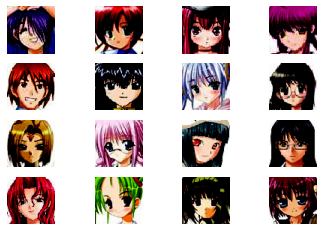

In [79]:
def save_plot(x_input,n=4):
    for i in range(n*n):
        plt.subplot(n, n, i+1)
        plt.imshow(x_input[i,:,:,:])
        plt.axis('off')
    plt.show()
# plot data
save_plot(k[:16])

## Generate real sample function

In [80]:
def generate_real_samples(dataset, n_samples):
	images = dataset
	ix = randint(0, images.shape[0], n_samples)
	X = images[ix]
	z = np.random.randint(0,5,size=(n_samples))
	y = ones((n_samples, 1))
	return [X,z], y
d = generate_real_samples(k, 32)
print("Generate real data as a batch randomly: ",d[0][0].shape)

Generate real data as a batch randomly:  (32, 64, 64, 3)


## Generate latent point function

In [81]:
def generate_latent_points(latent_dim, n_samples):
  x_input = randn(latent_dim * n_samples)
  z_input = x_input.reshape(n_samples, latent_dim)
  z = np.random.randint(0,5,size=(n_samples))
  return [z_input,z]
p = generate_latent_points(512, 32)
print("Generate latent point(with label) as a batch: ",p[0].shape)

Generate latent point(with label) as a batch:  (32, 512)


## Generate Fake samples of image with label

In [82]:
def generate_fake_samples(generator, latent_dim, n_samples):
	z_input,z = generate_latent_points(latent_dim, n_samples)
	images = generator.predict([z_input,z])
	y = zeros((n_samples, 1))
	return [images, z], y
with tf.device(device_name):
	kh = generate_fake_samples(b, 512, 32)
	print("shape of the generated images: ",kh[0][0].shape)

shape of the generated images:  (32, 64, 64, 3)


## Summarize the generator model

In [83]:
def summarize_the_model(generator,latent_dim = 100):
    latent_points = generate_latent_points(latent_dim= latent_dim, n_samples= 16)
    X  = generator.predict(latent_points)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    save_plot(X, n=4)

## Train function

In [84]:
# def train(g_model, d_model, gan_model, dataset, latent_dim= 100, n_epochs=3, n_batch=16):

#   print("\nNo. of epoch: ",n_epochs)
#   bat_per_epo = int(dataset.shape[0] / n_batch)
#   print("\nbatch per epoch: ", bat_per_epo)
#   half_batch = int(n_batch / 2)
#   print("\nfull batch: ", n_batch)
#   print("\nhalf batch: ", half_batch,'\n')
#   print("*"*50,'\n\n')

#   g_loss_array = []
#   d_loss_array = []
#   for i in range(n_epochs):
#     d_loss = 0.0
#     g_loss = 0.0
    
#     for j in range(bat_per_epo):

#       X_real, y_real = generate_real_samples(dataset, half_batch+1)
#       X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch+1)
#       X_actual_image = np.vstack((X_real,X_fake))
#       X_actual_target = np.vstack((y_real,y_fake))
#       d_loss_temp = 0.0
#       for dk in range(1):
#         x,_,y,_ = train_test_split(X_actual_image, X_actual_target, test_size=0.00001, random_state=42)
#         d_loss_temp_1, _ = d_model.train_on_batch(x, y)
#         d_loss_temp += d_loss_temp_1
#       d_loss += (d_loss_temp/1.0)


#       z_input = generate_latent_points(latent_dim, n_batch)
#       y_gan = ones((n_batch, 1))
#       g_loss1,_ = gan_model.train_on_batch(z_input, y_gan)
#       g_loss += g_loss1

#     d_loss_array.append(d_loss)
#     g_loss_array.append(g_loss)

#     print('epoch -> [%d/%d], discriminator_loss = %.2f, generator_loss = %.2f\n' %(i+1, n_epochs, d_loss, g_loss))
#     summarize_the_model(g_model,latent_dim)
#     g_model.save("/content/drive/MyDrive/Animo/DataSet1/generator_model_12.h5")
#     np.savez_compressed("/content/drive/MyDrive/Animo/DataSet1/loss_record_12.npz", a=d_loss_array, b=g_loss_array)

#     print("\n")

#   return d_loss_array, g_loss_array

In [85]:
def train(g_model, d_model, gan_model, dataset, latent_dim= 100, n_epochs=3, n_batch=128):

  print("No. of epoch: ",n_epochs)
  bat_per_epo = int(dataset.shape[0] / n_batch)
  print("batch per epoch: ", bat_per_epo)
  half_batch = int(n_batch / 2)
  print("half batch: ", half_batch,'\n')
  print("*"*50,'\n\n')

  d_loss_real_array,d_loss_fake_array =[],[]
  g_loss_array = []
  for i in range(n_epochs):
    d_loss_r,d_loss_f = 0.0,0.0
    g_loss = 0.0
    
    for j in range(bat_per_epo):

      [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
      d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
      d_loss_r += d_loss1
      # print("real_loss")

      [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
      d_loss_f += d_loss2
      # print("fake_loss")

      [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
      y_gan = ones((n_batch, 1))
      g_loss1,_ = gan_model.train_on_batch([z_input, labels_input], y_gan)
      g_loss += g_loss1

    d_loss_real_array.append(d_loss_r)
    d_loss_fake_array.append(d_loss_f)
    g_loss_array.append(g_loss)

    print('epoch -> [%d/%d], discriminator_loss_for_real_data = %.2f, discriminator_loss_for_fake_data = %.2f, generator_loss = %.2f\n' %(i+1, n_epochs, d_loss_r, d_loss_f, g_loss))
    summarize_the_model(g_model,latent_dim)
    # g_model.save("g_gan_model_"+str(i)+".h5")
    # g_model.save("/content/drive/MyDrive/CGAN_mnist/generator_model.h5")
    # np.savez_compressed('/content/drive/MyDrive/CGAN_mnist/loss_record.npz', a=d_loss_real_array, b=d_loss_fake_array, c=g_loss_array)

    print("\n")

  return d_loss_real_array, d_loss_fake_array, g_loss_array

## Main function


READY TO GO !!!

No. of epoch:  50
batch per epoch:  312
half batch:  16 

************************************************** 


epoch -> [1/50], discriminator_loss_for_real_data = 132.68, discriminator_loss_for_fake_data = 121.47, generator_loss = 965.09



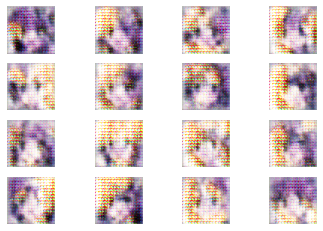



epoch -> [2/50], discriminator_loss_for_real_data = 157.04, discriminator_loss_for_fake_data = 156.95, generator_loss = 573.29



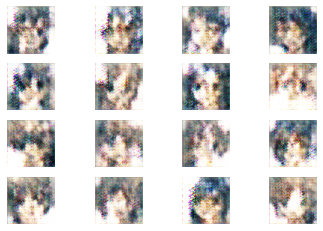



epoch -> [3/50], discriminator_loss_for_real_data = 170.83, discriminator_loss_for_fake_data = 173.92, generator_loss = 508.20



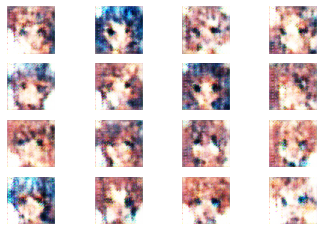



epoch -> [4/50], discriminator_loss_for_real_data = 191.09, discriminator_loss_for_fake_data = 194.89, generator_loss = 396.96



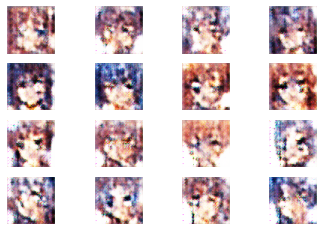



epoch -> [5/50], discriminator_loss_for_real_data = 194.66, discriminator_loss_for_fake_data = 195.21, generator_loss = 348.16



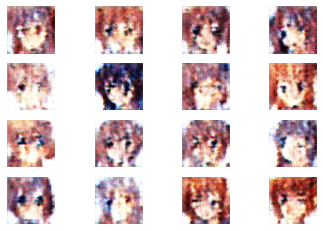



epoch -> [6/50], discriminator_loss_for_real_data = 189.59, discriminator_loss_for_fake_data = 193.10, generator_loss = 351.98



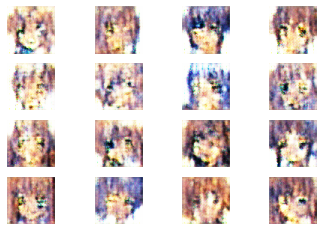



epoch -> [7/50], discriminator_loss_for_real_data = 191.76, discriminator_loss_for_fake_data = 187.99, generator_loss = 355.19



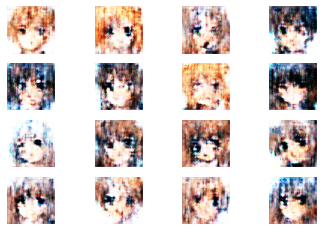



epoch -> [8/50], discriminator_loss_for_real_data = 192.08, discriminator_loss_for_fake_data = 194.56, generator_loss = 306.27



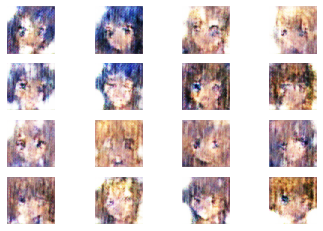



epoch -> [9/50], discriminator_loss_for_real_data = 187.01, discriminator_loss_for_fake_data = 183.18, generator_loss = 351.16



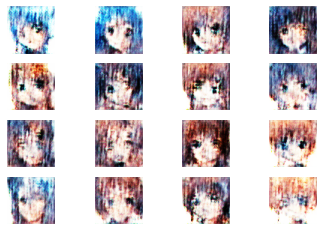



epoch -> [10/50], discriminator_loss_for_real_data = 174.19, discriminator_loss_for_fake_data = 175.15, generator_loss = 396.83



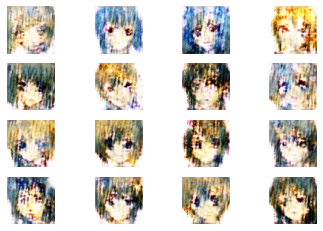



epoch -> [11/50], discriminator_loss_for_real_data = 179.71, discriminator_loss_for_fake_data = 173.44, generator_loss = 367.53



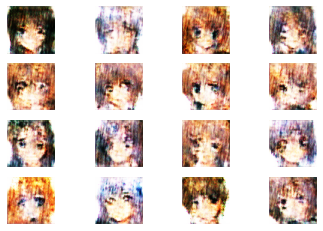



epoch -> [12/50], discriminator_loss_for_real_data = 172.99, discriminator_loss_for_fake_data = 171.62, generator_loss = 382.98



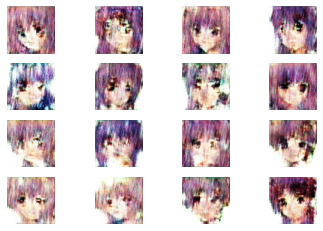



epoch -> [13/50], discriminator_loss_for_real_data = 178.92, discriminator_loss_for_fake_data = 177.36, generator_loss = 373.09



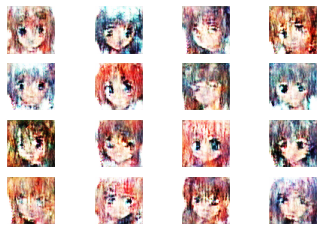



epoch -> [14/50], discriminator_loss_for_real_data = 193.29, discriminator_loss_for_fake_data = 193.07, generator_loss = 294.21



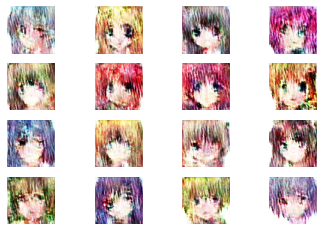



epoch -> [15/50], discriminator_loss_for_real_data = 189.23, discriminator_loss_for_fake_data = 190.62, generator_loss = 308.91



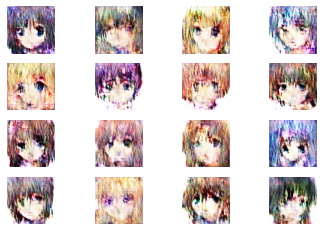



epoch -> [16/50], discriminator_loss_for_real_data = 184.51, discriminator_loss_for_fake_data = 191.59, generator_loss = 312.71



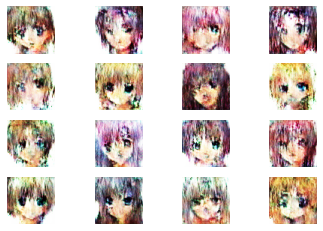



epoch -> [17/50], discriminator_loss_for_real_data = 184.47, discriminator_loss_for_fake_data = 187.98, generator_loss = 315.71



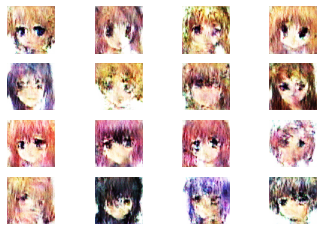



epoch -> [18/50], discriminator_loss_for_real_data = 182.11, discriminator_loss_for_fake_data = 187.04, generator_loss = 318.00



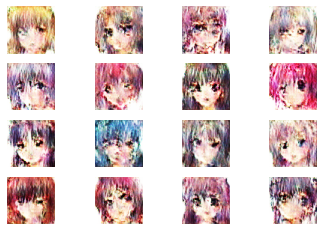



epoch -> [19/50], discriminator_loss_for_real_data = 179.61, discriminator_loss_for_fake_data = 184.50, generator_loss = 322.30



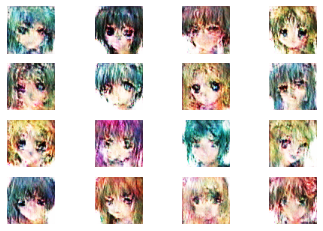



epoch -> [20/50], discriminator_loss_for_real_data = 168.20, discriminator_loss_for_fake_data = 170.76, generator_loss = 391.66



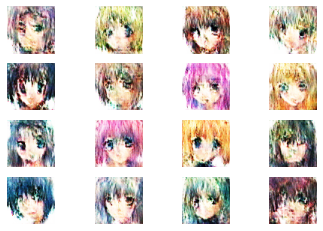



epoch -> [21/50], discriminator_loss_for_real_data = 173.86, discriminator_loss_for_fake_data = 176.55, generator_loss = 341.69



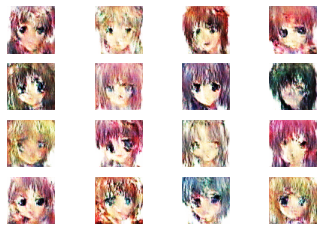



epoch -> [22/50], discriminator_loss_for_real_data = 171.32, discriminator_loss_for_fake_data = 174.95, generator_loss = 352.64



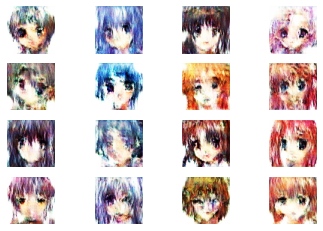



epoch -> [23/50], discriminator_loss_for_real_data = 170.32, discriminator_loss_for_fake_data = 172.57, generator_loss = 361.71



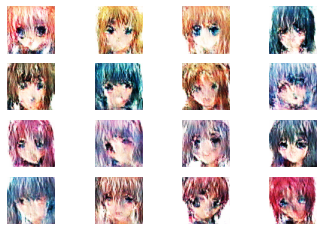



epoch -> [24/50], discriminator_loss_for_real_data = 165.95, discriminator_loss_for_fake_data = 170.47, generator_loss = 370.81



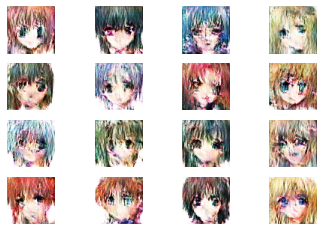



epoch -> [25/50], discriminator_loss_for_real_data = 163.72, discriminator_loss_for_fake_data = 169.18, generator_loss = 383.90



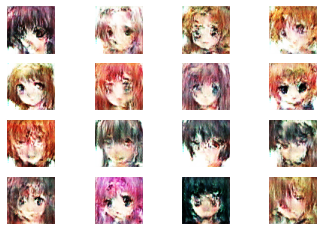



epoch -> [26/50], discriminator_loss_for_real_data = 160.21, discriminator_loss_for_fake_data = 160.64, generator_loss = 403.16



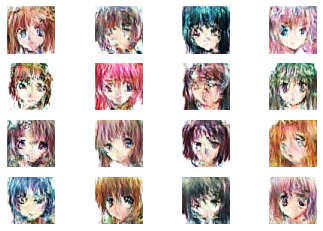



epoch -> [27/50], discriminator_loss_for_real_data = 160.17, discriminator_loss_for_fake_data = 163.82, generator_loss = 393.75



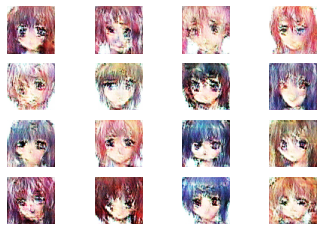



epoch -> [28/50], discriminator_loss_for_real_data = 156.82, discriminator_loss_for_fake_data = 159.60, generator_loss = 400.10



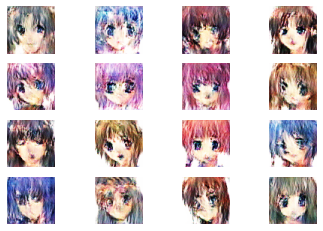



epoch -> [29/50], discriminator_loss_for_real_data = 152.95, discriminator_loss_for_fake_data = 155.14, generator_loss = 422.07



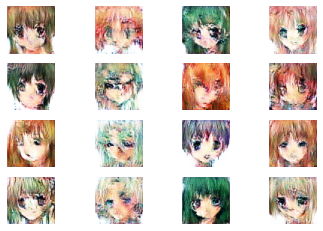



epoch -> [30/50], discriminator_loss_for_real_data = 152.82, discriminator_loss_for_fake_data = 155.38, generator_loss = 420.16



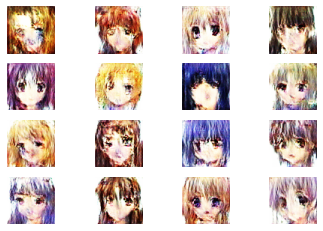



epoch -> [31/50], discriminator_loss_for_real_data = 150.28, discriminator_loss_for_fake_data = 155.59, generator_loss = 430.42



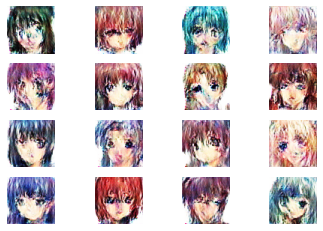



epoch -> [32/50], discriminator_loss_for_real_data = 146.83, discriminator_loss_for_fake_data = 148.46, generator_loss = 435.62



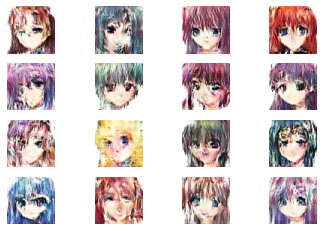



epoch -> [33/50], discriminator_loss_for_real_data = 143.66, discriminator_loss_for_fake_data = 148.49, generator_loss = 453.71



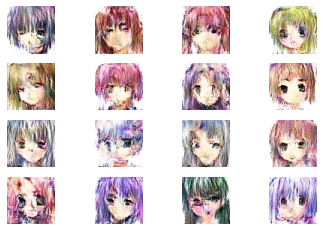



epoch -> [34/50], discriminator_loss_for_real_data = 140.44, discriminator_loss_for_fake_data = 144.51, generator_loss = 460.05



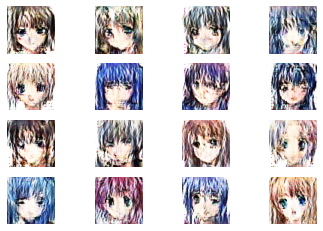



epoch -> [35/50], discriminator_loss_for_real_data = 141.22, discriminator_loss_for_fake_data = 143.57, generator_loss = 480.58



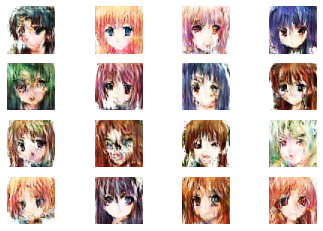



epoch -> [36/50], discriminator_loss_for_real_data = 134.47, discriminator_loss_for_fake_data = 137.78, generator_loss = 505.02



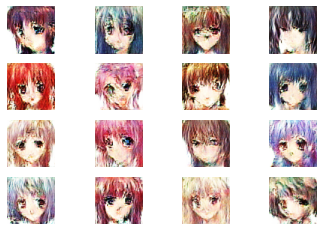



epoch -> [37/50], discriminator_loss_for_real_data = 135.91, discriminator_loss_for_fake_data = 135.88, generator_loss = 505.35



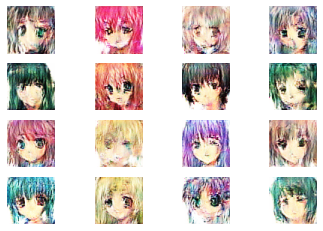



epoch -> [38/50], discriminator_loss_for_real_data = 129.68, discriminator_loss_for_fake_data = 135.91, generator_loss = 508.23



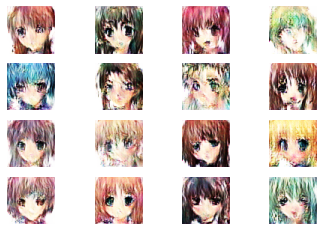



epoch -> [39/50], discriminator_loss_for_real_data = 127.01, discriminator_loss_for_fake_data = 130.99, generator_loss = 513.13



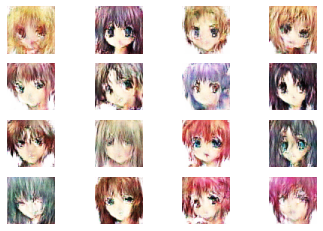



epoch -> [40/50], discriminator_loss_for_real_data = 122.62, discriminator_loss_for_fake_data = 127.44, generator_loss = 534.64



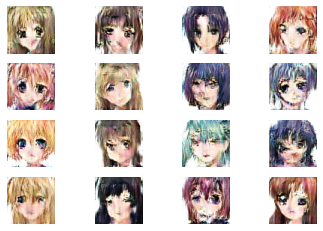



epoch -> [41/50], discriminator_loss_for_real_data = 120.96, discriminator_loss_for_fake_data = 123.99, generator_loss = 555.84



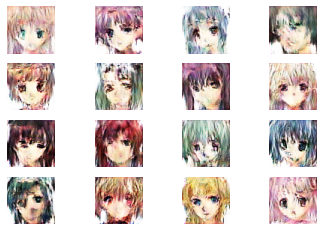



epoch -> [42/50], discriminator_loss_for_real_data = 117.15, discriminator_loss_for_fake_data = 124.06, generator_loss = 577.05



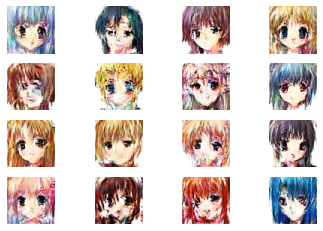



epoch -> [43/50], discriminator_loss_for_real_data = 115.35, discriminator_loss_for_fake_data = 120.41, generator_loss = 584.93



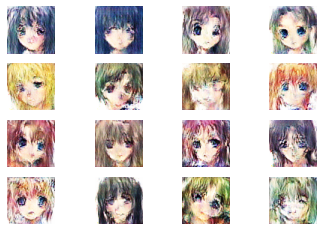



epoch -> [44/50], discriminator_loss_for_real_data = 109.97, discriminator_loss_for_fake_data = 120.76, generator_loss = 599.82



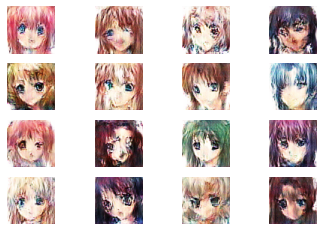



epoch -> [45/50], discriminator_loss_for_real_data = 110.22, discriminator_loss_for_fake_data = 114.83, generator_loss = 616.95



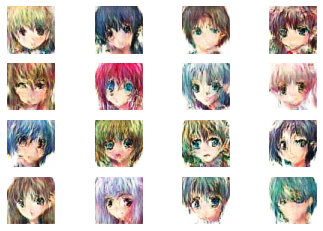



epoch -> [46/50], discriminator_loss_for_real_data = 105.40, discriminator_loss_for_fake_data = 113.93, generator_loss = 646.92



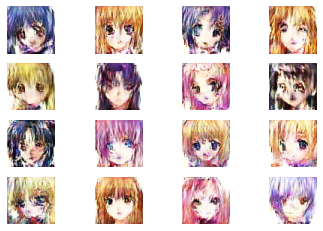



epoch -> [47/50], discriminator_loss_for_real_data = 104.43, discriminator_loss_for_fake_data = 109.65, generator_loss = 641.05



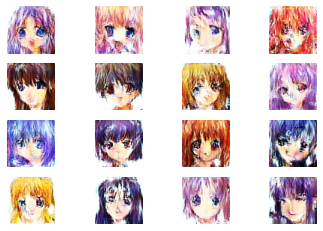



epoch -> [48/50], discriminator_loss_for_real_data = 97.92, discriminator_loss_for_fake_data = 104.08, generator_loss = 685.47



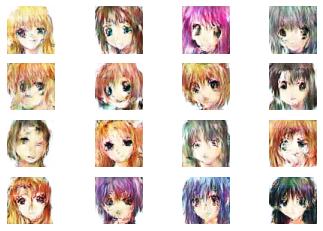



epoch -> [49/50], discriminator_loss_for_real_data = 100.30, discriminator_loss_for_fake_data = 105.54, generator_loss = 688.59



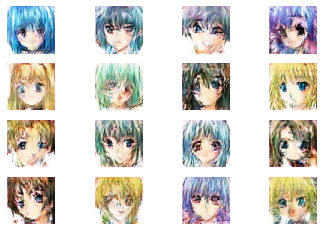



epoch -> [50/50], discriminator_loss_for_real_data = 95.81, discriminator_loss_for_fake_data = 102.97, generator_loss = 708.75



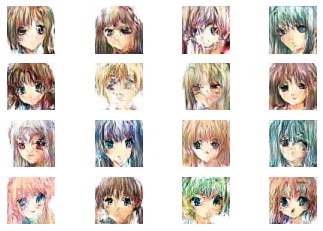

In [86]:
with tf.device(device_name):

  latent_dim = 512
  n_epochs = 50
  n_batch = 32
  d_model = define_discriminator()
  g_model = define_generator(latent_dim)
  gan_model = define_gan(g_model, d_model)
  dataset = load_real_samples()
  print('\nREADY TO GO !!!\n')
  
  d_loss_real_array, d_loss_fake_array, g_loss_array = train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, n_batch)

## Plot Loss Values

In [93]:
g_model.save("/content/sample_data/generator_model_c_dcgan.h5")

In [87]:
# loaded = np.load('/content/drive/MyDrive/Animo/DataSet1/loss_record_12.npz')
# print(loaded['a'].shape)
# print(loaded['b'].shape)

In [88]:
import matplotlib.pyplot as plot

# d_loss = np.array(loaded['a'])
# g_loss = np.array(loaded['b'])

In [100]:
d_loss = np.array([(i+j) for i,j in zip(d_loss_real_array, d_loss_fake_array)])

In [101]:
g_loss = g_loss_array

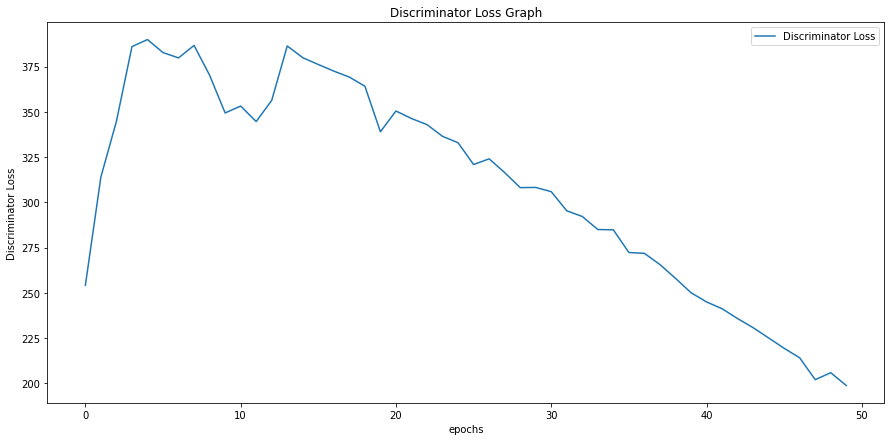

In [102]:
plt.figure(figsize=(15,7))
plt.plot(d_loss)
plt.title('Discriminator Loss Graph')
plt.ylabel('Discriminator Loss')
plt.xlabel('epochs')
plt.legend(["Discriminator Loss"], loc='upper right')
plt.show()

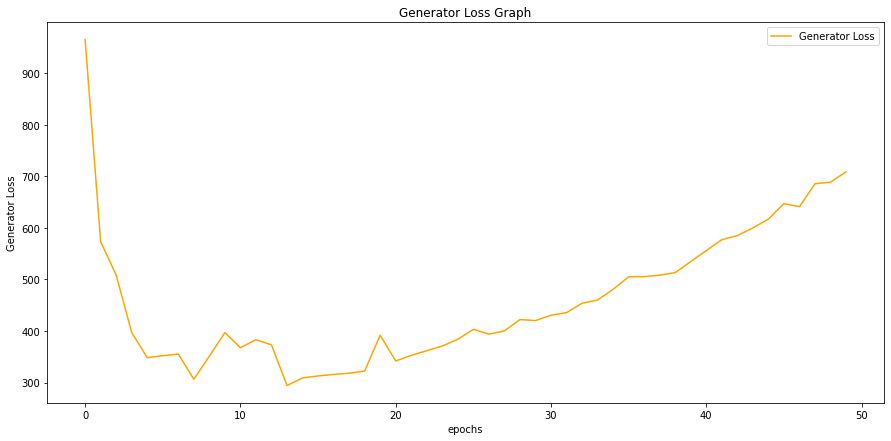

In [103]:
plt.figure(figsize=(15,7))
plt.plot(g_loss,color='orange')
plt.title('Generator Loss Graph')
plt.ylabel('Generator Loss')
plt.xlabel('epochs')
plt.legend(["Generator Loss"], loc='upper right')
plt.show()

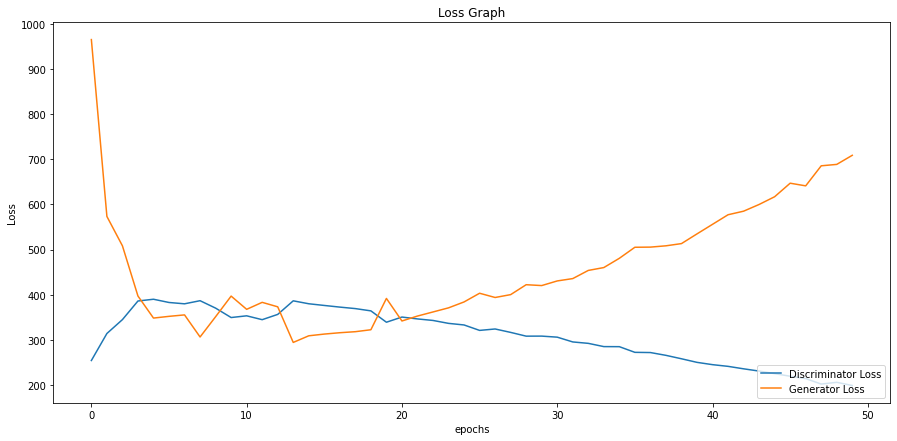

In [104]:
plt.figure(figsize=(15,7))
plt.plot(d_loss)
plt.plot(g_loss)
plt.title('Loss Graph')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend(["Discriminator Loss", "Generator Loss"], loc='lower right')
plt.show()

# Prediction

In [95]:
generator = tensorflow.keras.models.load_model("/content/sample_data/generator_model_c_dcgan.h5")

latent points(latent points and labels):  (16, 512) (16,)

Generated images with labels:  (16, 64, 64, 3) 



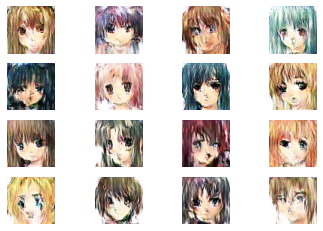

In [99]:
latent_dim = 512
n_samples = 16
z_input, labels = generate_latent_points(latent_dim, n_samples)
print("latent points(latent points and labels): ",z_input.shape, labels.shape)
data = [z_input,labels]
pred = generator.predict(data)
pred = (pred +1 ) / 2.0
print("\nGenerated images with labels: ",pred.shape,'\n')
save_plot(pred,n=4)

                                              -:END:-